In [1]:
# https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers
import torch
import torch.nn as nn
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer, sentencepiece_numericalizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import math
from torch.utils.data import Dataset, DataLoader
import torch.utils.data.dataloader as dataloader
import os
import re

In [2]:
root = "dataset"

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.	positive
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.	positive
I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.	positive

In [3]:
with open(os.path.join(root, "imdb.csv")) as f:
        with open(os.path.join(root, "data.txt"), "w") as f2:
            for line in f:
                text_only = "".join(line.split(",")[:-1])
                filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # Replaces double quotes with a space, and \n with a space
                # Replaces \\, \\n, and; with a space
                # Replaces HTML codes with real characters
                filtered = filtered.replace(' #39;', "'")
                filtered = filtered.replace(' #38;', "&")
                filtered = filtered.replace(' #36;', "$")
                filtered = filtered.replace(' #151;', "-")
                f2.write(filtered.lower() + "\n")

In [4]:
# Generate the SentencePiece tokenizer
# Text tokenizer and detokenizer
# It will tokenize words into subpieces instead of words
# This function will create a set of subtokens to fit the set vocabulary size
# There will always be enough subwords to subtokenize a dataset if you think about it :) -> max 2 length pairs = 26!
# Saved in the home directory
# generate_sp_model(os.path.join(root, "data.txt"), vocab_size=40000, model_prefix='SentencePiece/transformer')

In [5]:
# Class must inherit from Dataset to use DataLoader from torch
class IMDB(Dataset):
    def __init__(self):

        # Reads the file into a pandas DataFrame
        self.df = pd.read_csv(os.path.join(root, "imdb.csv"), names=["Article", "Class"])

        # Replaces empty entries with a space
        self.df.fillna('', inplace=True)

        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)
        self.df['Article'] = self.df['Article'].replace({' #39;': "'", ' #38;': "&", ' #36;': "$", ' #151;': "-"}, regex=True)

    # To use for DataLoader
    def __getitem__(self, index):
        text = self.df.loc[index]["Article"].lower()
        
        class_label = self.df.loc[index]["Class"]

        if class_label == 'positive':
            class_index = 1
        else:
            class_index = 0
            
        return class_index, text

    def __len__(self):
        return len(self.df)

train_dataset = IMDB()
print(len(train_dataset))
print(train_dataset.df.loc[0]["Article"])
train_dataset.df.loc[0]["Class"]

50000
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to t

'positive'

In [6]:
# Split 90% - 10%
validation_split = 0.9

# Total train examples
n_train_examples = int(len(train_dataset) * validation_split)

# Total validation examples
n_valid_examples = len(train_dataset) - n_train_examples

# Splits them based on values provided
train_data, valid_data = torch.utils.data.random_split(train_dataset, [n_train_examples, n_valid_examples], generator=torch.Generator().manual_seed(42))

In [7]:
# Create dataloaders for the training and testing datasets
# Dataloaders allow for batching, shuffling

batch_size = 128

train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)

test_loader = dataloader.DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last = True)

In [8]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate through each line in the file
        for line in f:
            # Accesses the vocab file, splits the line by tab, and gets the first entry (the actual token)
            # Yield the token from the first column (split by tab)
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library (build_vocab_from_iterator)
# Builds a generator object, that is treated like an iterator
vocab = build_vocab_from_iterator(yield_tokens("SentencePiece/transformer.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'], special_first=True)

# Set the default index for unknown tokens to the index of the '<unk>' token
vocab.set_default_index(vocab['<unk>'])

In [9]:
vocab.get_itos()

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!',
 '!!!!!!',
 '!!!!!!!',
 '!!!!!!!!',
 '!!!!!!!!!',
 '!!!!!!!!!!',
 '!!!!!!!!!!!',
 '!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!',
 '!!!!!!!!!!!!!!!!',
 '!!!!!)',
 '!!!)',
 '!!!???',
 '!!)',
 '!!).',
 '!!??',
 '!)',
 '!).',
 '!).<',
 '!<',
 '!?',
 '!?!',
 '!?!)',
 '!?!?',
 "'",
 "'95",
 '(',
 '(!)',
 '(!?)',
 '(..',
 '(1',
 '(193',
 '(1940)',
 '(195',
 '(199',
 '(2)',
 '(2005)',
 '(3)',
 '(7/10',
 '(?)',
 ')',
 ')--',
 ').',
 ')...',
 ').<',
 '):',
 '*',
 '*)',
 '**',
 '**)',
 '***',
 '***)',
 '****',
 '*****',
 '******',
 '*******',
 '********',
 '*********',
 '**********',
 '************',
 '***************',
 '****************',
 '****/*****',
 '***/****',
 '**1/2',
 '*1/2',
 '-',
 "-'80",
 "-'90",
 '--',
 '---',
 '-----',
 '------',
 '-------',
 '------------',
 '----------------',
 '---->',
 '-->',
 '-1',
 '-10',
 '-12',
 '-13',
 '-14',
 '-17',
 '-18',
 '-19',
 '-1940',
 '-1945',
 '-1950',
 '-1970',
 '-1980',
 '-20

In [25]:
# print(vocab['<pad>'])  # Should print the index of <pad>
# print(vocab['<sos>'])  # Should print the index of <sos>
# print(vocab['<eos>'])  # Should print the index of <eos>
# print(vocab['<unk>'])  # Should print the index of <unk>
# print(vocab['▁hello'])   # Should print the index of ▁the (if present)
# print(vocab['unknown_token'])  # Should print the index of <unk> as it's not in vocab

In [10]:
# Maximum sequence length for text inputs
max_len = 256

# Data transform to turn text into vocab tokens

# Takes in a list, converts to a tensor
text_transform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("SentencePiece/transformer.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(vocab['<sos>'], begin=True),
    # Crop the sentance if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(vocab['<eos>'], begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

In [12]:
# Expects a tensor of tokens, and turns some of these tokens into padding tokens
class TokenDrop(nn.Module):
    """ For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    prob (float): probability of dropping a token
    pad_token (int): index for the <pad> token
    num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p = prob
        # Create a mask where 1 means we will replace that token
        # Discrete probability distribution
        # Here we want to treat the ones as the indexes to drop
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # Only replace if the token is not a special token
        # Ones or zeros. If cannot drop, 0, if can drop, 1
        can_drop = (sample >= self.num_special).long()
        # Multiply together to get the corresponding tokens to be dropped and not dropped
        # Here, 1 represents drop, 0 represents do not drop
        mask = mask * can_drop

        # Make a mask of pad_token to use for replacing dropped indices with the pad_token
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        """ 
        Sample is the original sample
        The mask indicates what tokens can be replaced (0 to not be replaced, 1 to be replaced)
        Replace_with is a list of of the pad_token tokens
        Here, (1-mask) creates the complement mask. (now, 0 indicates drop, 1 indicates to not drop)
        1-1 = 0, 1-0 = 0
        Multiplying by sample, retains the original tokens that are not to be kept, and applies the mask on the sample
        Here, mask * replace_with does elementwise multiplication and adds the corresponding pad_token to the tokens replaced
        """
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [13]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        # Get the device of the input tensor
        device = x.device
        
        # Calculate half of the hidden size
        half_dim = self.dim // 2
        
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        
        return emb

In [16]:
class NanoTransformer(nn.Module):
    """
        This class implements a simplified Transformer model for sequence classification. 
        It uses an embedding layer for tokens, sinusoidal positional embeddings, 
        a Transformer, and a Linear layer.
        
        num_emb: The number of unique tokens in the vocabulary. (vocab_size)
        output_size: The size of the output layer (number of classes). (4)
        hidden_size: The dimension of the hidden layer in the Transformer block (default: 128)
        num_heads: The number of heads in the multi-head attention layer (default: 4).
    """
    def __init__(self, num_emb, output_size, hidden_size=128, num_heads=4):
        
        # Inherits from nn.Module's attributes
        super(NanoTransformer, self).__init__()

        # Create an embedding for each token
        self.embedding = nn.Embedding(num_emb, hidden_size) # (vocab_size, 128)
        
        # Scaling down the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data
        
        # Positional embedding
        self.pos_emb = SinusoidalPosEmb(hidden_size)

        # Multi-head attention
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads = num_heads, batch_first = True)

        # Linear layer
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size), # (batch_size, 128, 128)
                                 nn.LayerNorm(hidden_size), # (batch_size, 128, 128)
                                 nn.ELU(), # (batch_size, 128, 128)
                                 nn.Linear(hidden_size, hidden_size)) # (batch_size, 128, 128)
        
        self.fc_out = nn.Linear(hidden_size, output_size) # (batch_size, 128, 128)

    def forward(self, input_seq):
        # batch_size, time_steps
        batch_size, l = input_seq.shape # (32, 160)

        input_embs = self.embedding(input_seq) # (32, 160) -> (32, 160, 128)
        
        # Add a unique embedding to each token embedding depending on it's position in the sequence
        seq_indx = torch.arange(l) # (160)
        
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, -1).expand(batch_size, l, -1) # (1, 160, 128) -> (32, 160, 128)
        
        embs = input_embs + pos_emb # (32, 160, 128) + (32, 160, 128)
        
        output, attn_map = self.multihead_attn(embs, embs, embs) # (32, 160, 128)
        
        output = self.mlp(output) # (32, 160, 128)

        return self.fc_out(output), attn_map # (32, 160, 4)

In [17]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 1e-4

nepochs = 20

hidden_size = 256

output_size = 2

num_heads = 4

tf_classifier = NanoTransformer(num_emb=len(vocab), output_size=2, hidden_size=hidden_size, num_heads=num_heads).to(device)

# Initialize the optimizer
optimizer = optim.Adam(tf_classifier.parameters(), lr=learning_rate, weight_decay=1e-4)

# Cosine annealing scheduler to decay the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

loss_fn = nn.CrossEntropyLoss()
td = TokenDrop(prob=0.4)

training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []

In [120]:
# Loop over each epoch
for epoch in range(nepochs):
    tf_classifier.train()
    train_acc = 0
    train_steps = 0

    print("training")
    # Loop over each batch in the training dataset
    for labels, texts in train_loader:
        batch_size = labels.shape[0]
        
        # Transform the text to tokens and move to the GPU
        text_tokens = text_transform(list(texts)).to(device)
        labels = labels.to(device)
        
        # TokenDrop
        text_tokens = td(text_tokens)
        
        # Get the model predictions
        pred, _ = tf_classifier(text_tokens)
        
        # Compute the loss using cross-entropy loss
        loss = loss_fn(pred[:, 0, :], labels)
        
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        # Log the training loss
        training_loss_list.append(loss.item())
        
        # Update training accuracy
        train_acc += (pred[:, 0, :].argmax(1) == labels).sum().item()
        train_steps += batch_size
    
    # Calculate average training accuracy
    train_acc /= train_steps
    training_acc_list.append(train_acc)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Set the model to evaluation mode
    tf_classifier.eval()
    test_acc = 0
    test_steps = 0

    print("evaluating")
    # Loop over each batch in the testing dataset
    with torch.no_grad():
        for labels, texts in test_loader:
            batch_size = labels.shape[0]
            
            # Transform the text to tokens and move to the GPU
            text_tokens = text_transform(list(texts)).to(device)
            labels = labels.to(device)
            
            # Get the model predictions
            pred, _ = tf_classifier(text_tokens)
            
            # Compute the loss using cross-entropy loss
            loss = loss_fn(pred[:, 0, :], labels)
            test_loss_list.append(loss.item())
            
            # Update testing accuracy
            test_acc += (pred[:, 0, :].argmax(1) == labels).sum().item()
            test_steps += batch_size
        
        # Calculate average testing accuracy
        test_acc /= test_steps
        test_acc_list.append(test_acc)

    # Print out the results for this epoch
    print(f'Epoch {epoch+1}/{nepochs}')
    print(f'Training Accuracy: {train_acc*100:.2f}%')
    print(f'Testing Accuracy: {test_acc*100:.2f}%')

training
loss: 0.7031002640724182
loss: 0.6955245137214661
loss: 0.7734100222587585
loss: 0.7131149768829346
loss: 0.7400569915771484
loss: 0.6926537752151489
loss: 0.6947782635688782
loss: 0.724960207939148
loss: 0.7186017036437988
loss: 0.7092949151992798
loss: 0.6727327108383179
loss: 0.7022277116775513
loss: 0.6911002993583679
loss: 0.6901404857635498
loss: 0.6932653188705444
loss: 0.6933035254478455
loss: 0.6956195831298828
loss: 0.6906545162200928
loss: 0.6925488114356995
loss: 0.6856362223625183
loss: 0.6899688839912415
loss: 0.6870463490486145
loss: 0.6960800290107727
loss: 0.7250970602035522
loss: 0.6816826462745667
loss: 0.6913644671440125
loss: 0.7046886086463928
loss: 0.6927874088287354
loss: 0.6893103718757629
loss: 0.7019813656806946
loss: 0.694657027721405
loss: 0.697712242603302
loss: 0.6811060309410095
loss: 0.705312967300415
loss: 0.7245893478393555
loss: 0.6914802193641663
loss: 0.6971253752708435
loss: 0.6891341209411621
loss: 0.6930518746376038
loss: 0.698274075984


KeyboardInterrupt



In [93]:
# Save the model
torch.save(tf_classifier.state_dict(), 'model.pth')

In [95]:
# Load the model
loaded_model = NanoTransformer(num_emb=len(vocab), output_size=2, hidden_size=hidden_size, num_heads=num_heads)
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model.to(device)

NanoTransformer(
  (embedding): Embedding(20003, 256)
  (pos_emb): SinusoidalPosEmb()
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc_out): Linear(in_features=256, out_features=2, bias=True)
)

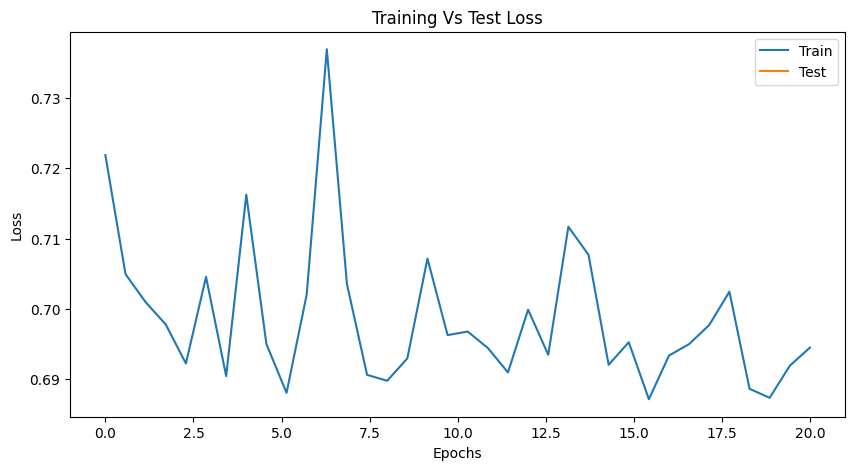

In [65]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_list)), training_loss_list)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_list)), test_loss_list)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

ValueError: zero-size array to reduction operation maximum which has no identity

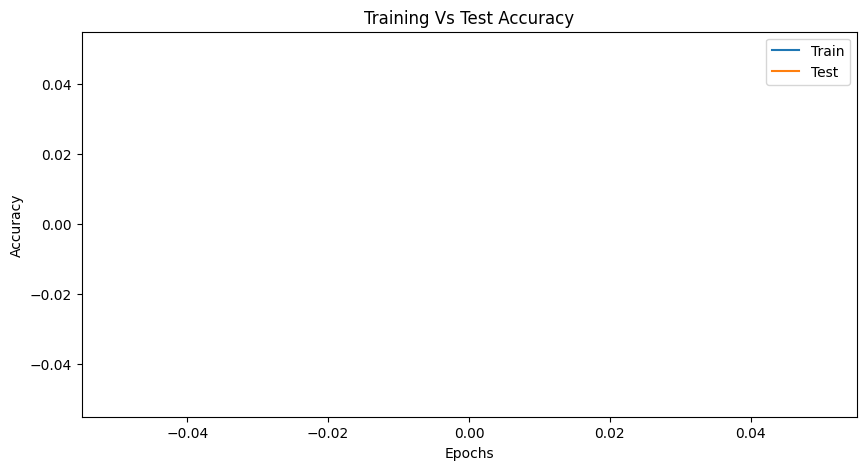

In [66]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_list)), training_acc_list)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_list)), test_acc_list)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")
print("Max Test Accuracy %.2f%%" % (np.max(test_acc_list) * 100))

In [46]:
ag_news_classes = [
    "negative",
    "positive"
]

with torch.no_grad():
    label, text = next(iter(train_loader))
    text_tokens = text_transform(list(text)).to(device)
    pred, attention_map = tf_classifier(text_tokens)

In [47]:
pred.shape

torch.Size([128, 129, 2])

In [48]:
test_index = 3

# Choose a text index smaller than the total number in the batch!
assert test_index < label.shape[0]

# Select the attention map for a single sample and the first attention head
att_map = attention_map[test_index, 0]
pred_class = ag_news_classes[pred[test_index, 0, :].argmax().item()]
top5 = att_map.argsort(descending=True)[:5]
top5_tokens = vocab.lookup_tokens(text_tokens[test_index, top5].cpu().numpy())


print("Article:")
print(text[test_index])
print("\nPredicted label:")
print(pred_class)
print("True label:")
print(ag_news_classes[label[test_index].item()])
print("\nTop 5 Tokens:")
print(top5_tokens)

Article:
walter matthau can always improve a mediocre film, and this movie proves it. he turns in a very realistic performance as a small-time horse trainer and single father, not sugar-coating either role.<br /><br />he can be, by turns, soft-hearted and doting, then iron-handed to his boys, and we can see the same dichotomy in his approach to horse training (we see that he doesn't want his young prospect racing horse overworked and hurt in small-time races, but he seems to be willing to risk the horse's life when he gets into the big time).<br /><br />this is just one of matthau's wonderful performances, and one that i highly recommend.

Predicted label:
negative
True label:
positive

Top 5 Tokens:
['▁not', '▁sugar', '<eos>', 'br', '-']


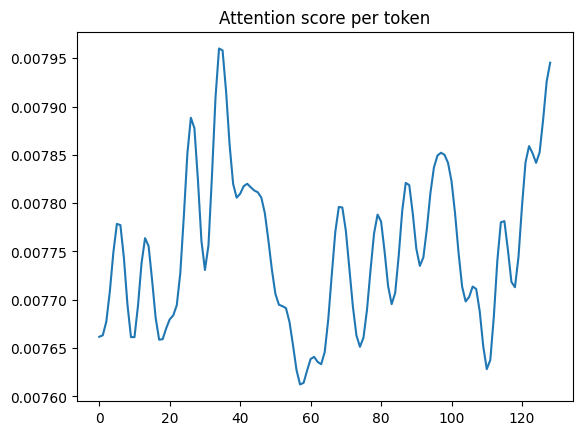

In [41]:
_ = plt.plot(att_map.cpu().numpy())
_ = plt.title("Attention score per token")